In [1]:
import torch
import math
import imageio.v2 as imageio
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
m1 = torch.tensor([5.,0.])
m2 = torch.tensor([0., 2.5])
t = .1
dt = 0.01
sigma = 3.
min_val = -6
max_val = 6

In [3]:
def calc_logsumexp(x, denom):
    return torch.exp(x - torch.logsumexp(denom, dim=0))

def uncond_score(x, t, m1, m2, Gamma_t, label=None, omega=None):
    exp_neg_t = torch.exp(-t)
    exp_neg_m1m2 = torch.exp(-m1 * m2 * exp_neg_t**2 / Gamma_t)
    exp_pos_m1m2 = torch.exp(m1 * m2 * exp_neg_t**2 / Gamma_t)
    x_dot_m1_plus_m2 = torch.dot(x, (m1 + m2))
    x_dot_m1_minus_m2 = torch.dot(x, (m1 - m2))

    arg1 = torch.log(exp_neg_m1m2) + x_dot_m1_plus_m2 * exp_neg_t / Gamma_t
    arg2 = torch.log(exp_neg_m1m2) - x_dot_m1_plus_m2 * exp_neg_t / Gamma_t
    arg3 = torch.log(exp_pos_m1m2) + x_dot_m1_minus_m2 * exp_neg_t / Gamma_t
    arg4 = torch.log(exp_pos_m1m2) - x_dot_m1_minus_m2 * exp_neg_t / Gamma_t

    denom = torch.stack([arg1, arg2, arg3, arg4], dim=0)
    l11 = (m1 + m2) * calc_logsumexp(arg1, denom)
    l12 = -(m1 + m2) * calc_logsumexp(arg2, denom)
    l21 = (m1 - m2) * calc_logsumexp(arg3, denom)
    l22 = - (m1 - m2) * calc_logsumexp(arg4, denom)

    S_i_t = (-x / Gamma_t) + (exp_neg_t / Gamma_t) * (l11 + l12 + l21 + l22)
    return S_i_t

def cond_score(x, t, m1, m2, Gamma_t, label=0, omega=None):
    score = (-x +((2*(label<2)-1) * m1 + (2*(label%2)-1) * m2) * torch.exp(-t)) / Gamma_t
    return score

def cfg(x, t, m1, m2, Gamma_t, omega, label=0):
    uncond_score_ = uncond_score(x, t, m1, m2, Gamma_t, label)
    cond_score_ = cond_score(x, t, m1, m2, Gamma_t, label)
    return (1+omega) * cond_score_ - omega * uncond_score_

In [ ]:
def get_vf(m1, m2, score_func, t, dt, sigma, n=10, min=-5, max=5, label=0, plot=False, omega=None):
    t, sigma = torch.tensor(t), torch.tensor(sigma)
    Gamma_t = sigma**2*torch.exp(-2*t) + dt

    xx, yy = torch.meshgrid(
    [torch.linspace(min, max, steps=n)]*2, indexing='ij')
    inp = torch.stack((xx, yy), dim=-1).reshape(-1, 2)

    conc = []
    for inp_ in inp:
        conc.append(score_func(inp_, t, m1, m2, Gamma_t, label=label, omega=omega))

    conc = torch.stack(conc).reshape(n, n, 2).detach().numpy()
    inp = inp.reshape(n, n, 2).detach().numpy()
    
    if plot:
        plt.figure(figsize=(8, 8))
        plt.quiver(inp[:,:,0],inp[:,:,1],conc[:,:,0],conc[:,:,1])
        for plots in [m1+m2, m1-m2, -m1+m2, -m1-m2]:
            plt.scatter(plots[0], plots[1], color='r', s=100)
        plt.show()
    return inp, conc

In [5]:
def generate_gif(gifname, score_func, m1, m2, dt, sigma, min_val, max_val, label=None, omega=None):
    images = []

    t_values = torch.flip(torch.linspace(0,2., steps=100),dims=[0])
    for t_value in tqdm(t_values):
        t = torch.tensor([t_value])
        inp, conc = get_vf(m1, m2, score_func, t, dt, sigma, n=25, min=min_val, max=max_val, label=label, omega=omega)

        plt.figure()
        plt.quiver(inp[:,:,0],inp[:,:,1],conc[:,:,0],conc[:,:,1])
        for plots in [m1+m2, m1-m2, -m1+m2, -m1-m2]:
            plt.scatter(plots[0], plots[1], color='r', s=100)
        plt.title(f't = {t_value:.2f}')
        plt.xlim(min_val, max_val)
        plt.ylim(min_val, max_val)
        

        plt_path = f'temp_plots/temp_{t_value:.2f}.png'
        plt.savefig(plt_path)
        plt.close()
        

        images.append(imageio.imread(plt_path))

    imageio.mimsave('gifs/'+gifname+'.gif', images, duration=0.05)

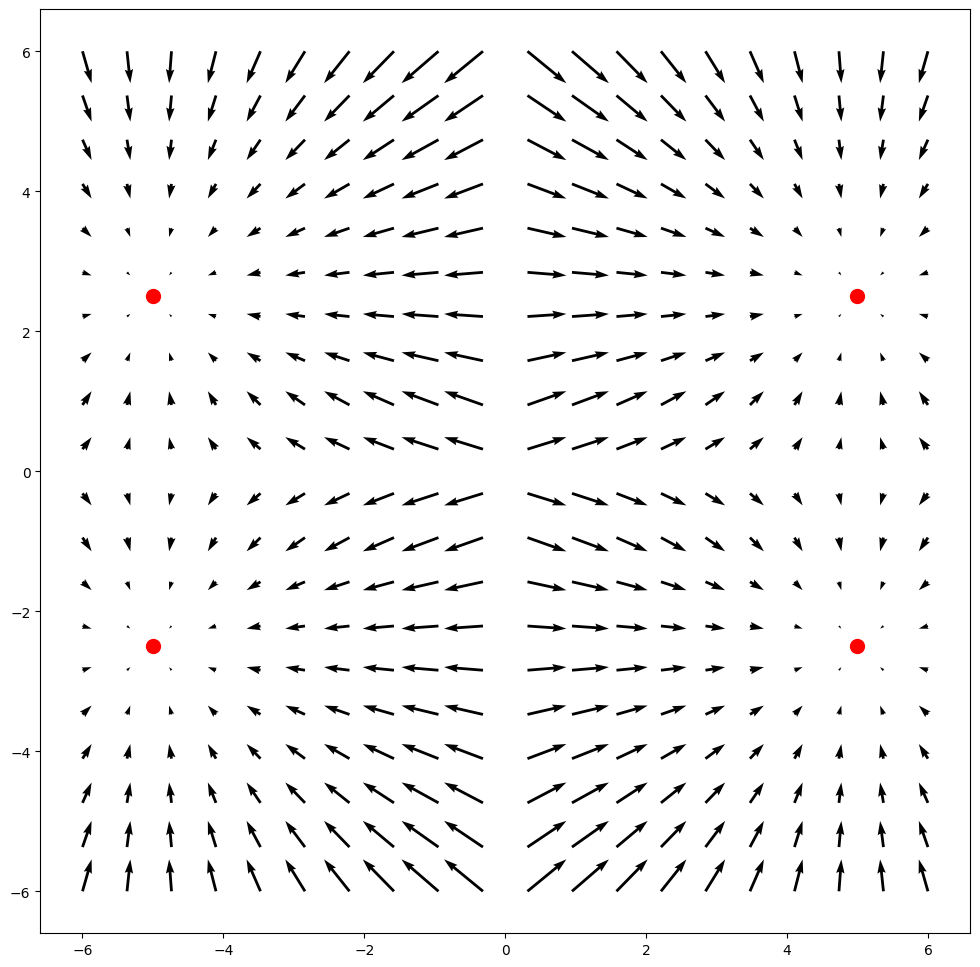

In [9]:
inp, conc = get_vf(m1, m2, uncond_score, t=0.0, dt=0.01, sigma=1., n=20, min=-6, max=6, plot=True)


In [ ]:
generate_gif('uncond_score', uncond_score, m1, m2, dt, sigma, min_val, max_val)

100%|██████████| 100/100 [00:34<00:00,  2.93it/s]


## Only CFG part (true score)

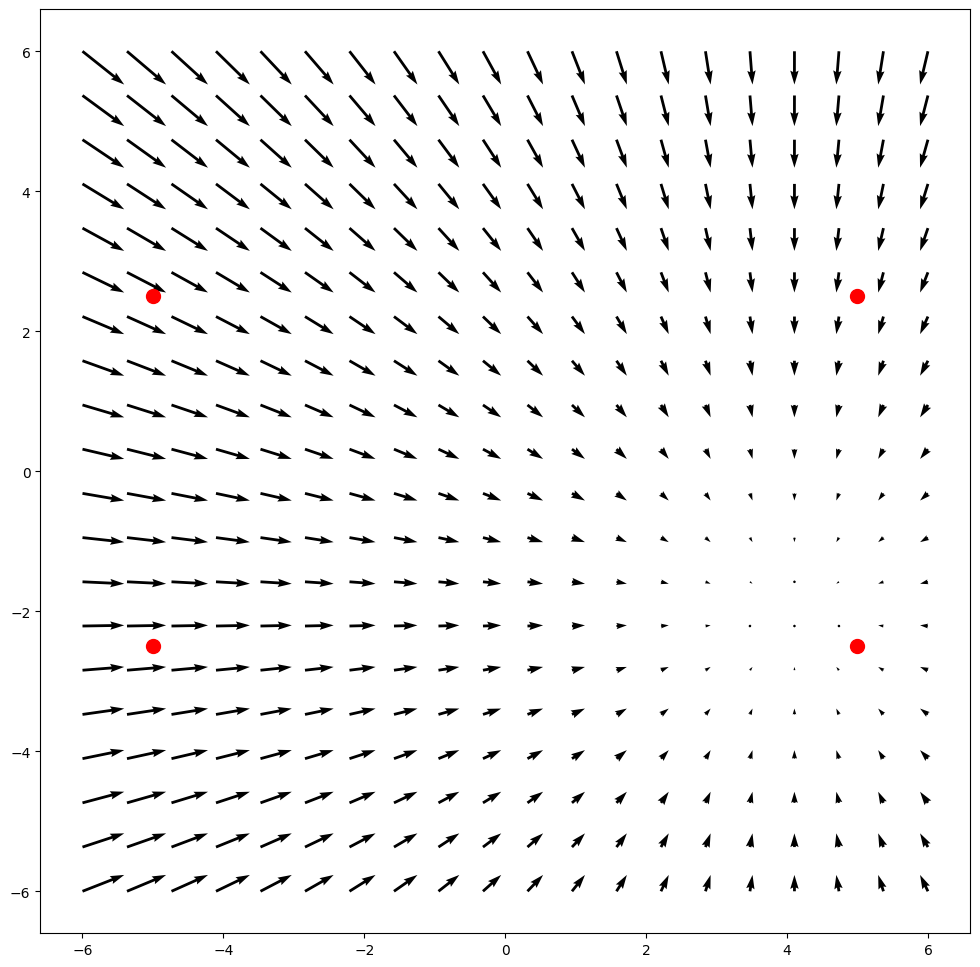

In [ ]:
inp, conc = get_vf(m1, m2, cond_score, t=0.2, dt=0.01, sigma=1., n=20, min=-6, max=6, plot=True)

In [17]:
generate_gif('cond_score', cond_score, m1, m2, dt, sigma, min_val, max_val, label=0)

100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


# CFG

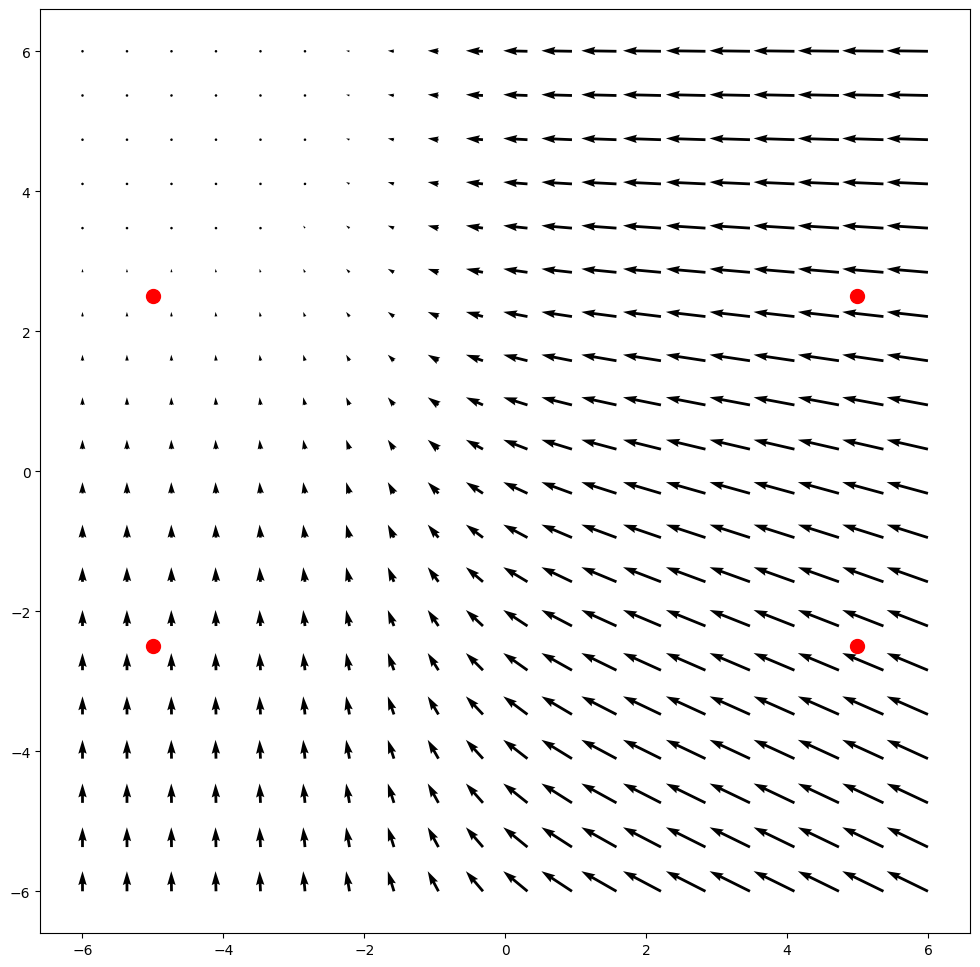

In [16]:
inp, conc = get_vf(m1, m2, cfg, omega=100., t=0., dt=0.01, sigma=3., n=20, min=-6, max=6, plot=True, label=3)

In [33]:
generate_gif('cfg_score', cfg, m1, m2, dt, sigma, min_val, max_val, label=0, omega=1.5)

100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


## All three

In [43]:
def plot_all_three(m1, m2, t, dt, sigma, omega, n=10, min=-5, max=5, label=0, plot=False):
    t, sigma = torch.tensor(t), torch.tensor(sigma)
    Gamma_t = sigma**2*torch.exp(-2*t) + dt
    xx, yy = torch.meshgrid(
    [torch.linspace(min, max, steps=n)]*2, indexing='ij')
    inp = torch.stack((xx, yy), dim=-1).reshape(-1, 2)
    
    conc1, conc2 = [], []
    for inp_ in inp:
        conc1.append(cond_score(inp_, t, m1, m2, Gamma_t, label))
        conc2.append(uncond_score(inp_, t, m1, m2, Gamma_t))
    conc1 = torch.stack(conc1).reshape(n, n, 2).detach().numpy()
    conc2 = torch.stack(conc2).reshape(n, n, 2).detach().numpy()
    conc = (1 + omega) * conc1 - omega * conc2
    inp = inp.reshape(n, n, 2).detach().numpy()
    
    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create 3 subplots side by side
        for ax, c in zip(axes, [conc1, conc2, conc]):
            ax.set_title(['Conditional vec. field, t= %.2f' % t, 'Unconditional vec. field, t= %.2f' % t, 'CFG vec. field, t= %.2f' % t][axes.tolist().index(ax)])
            ax.quiver(inp[:, :, 0], inp[:, :, 1], c[:, :, 0], c[:, :, 1])
            for plots in [m1+m2, m1-m2, -m1+m2, -m1-m2]:
                ax.scatter(plots[0], plots[1], color='black', s=25)
            # Add contours of 2D Gaussian
            for mean in [np.array([5, 2.5]), np.array([-5, 2.5]), np.array([-5, -2.5])]:
                circle1 = plt.Circle(mean, 1., color='b', fill=False)
                ax.add_patch(circle1)
            circle1 = plt.Circle((5,-2.5), 1., color='r', fill=False)
            ax.add_patch(circle1)
            ax.legend()
        plt.suptitle("CFG with $\omega$ = %.2f" % omega)
        plt.show()
    return inp, conc1, conc2, conc

/tmp/ipykernel_263520/4000017707.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


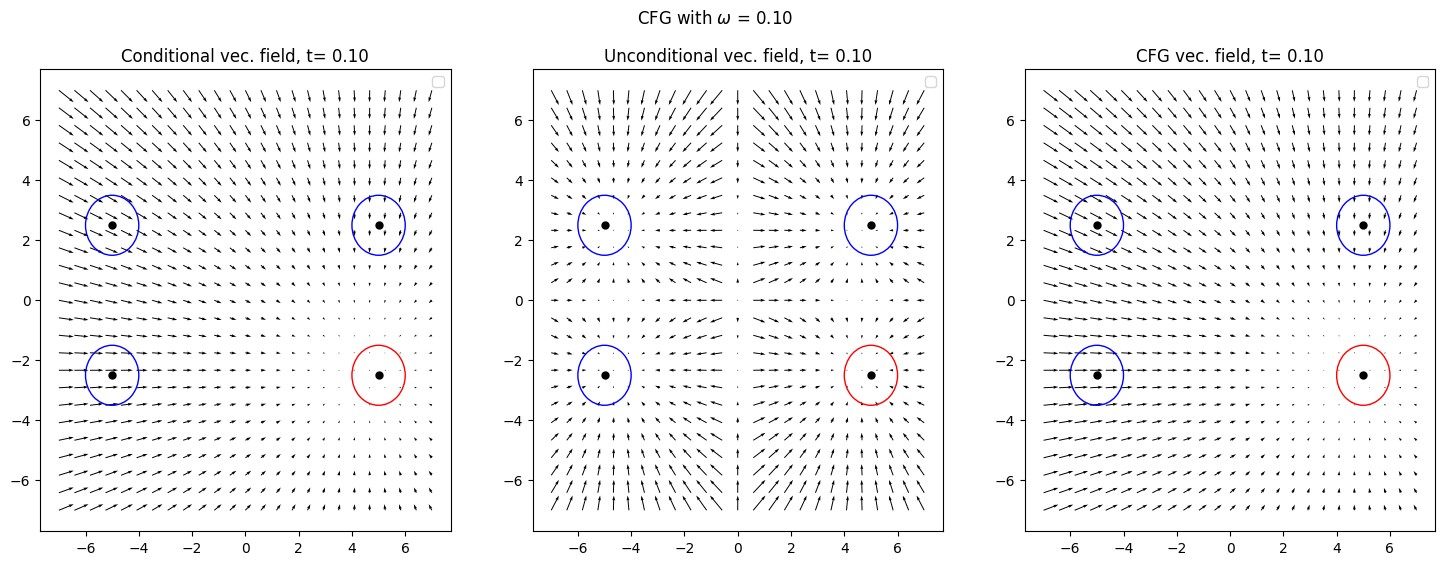

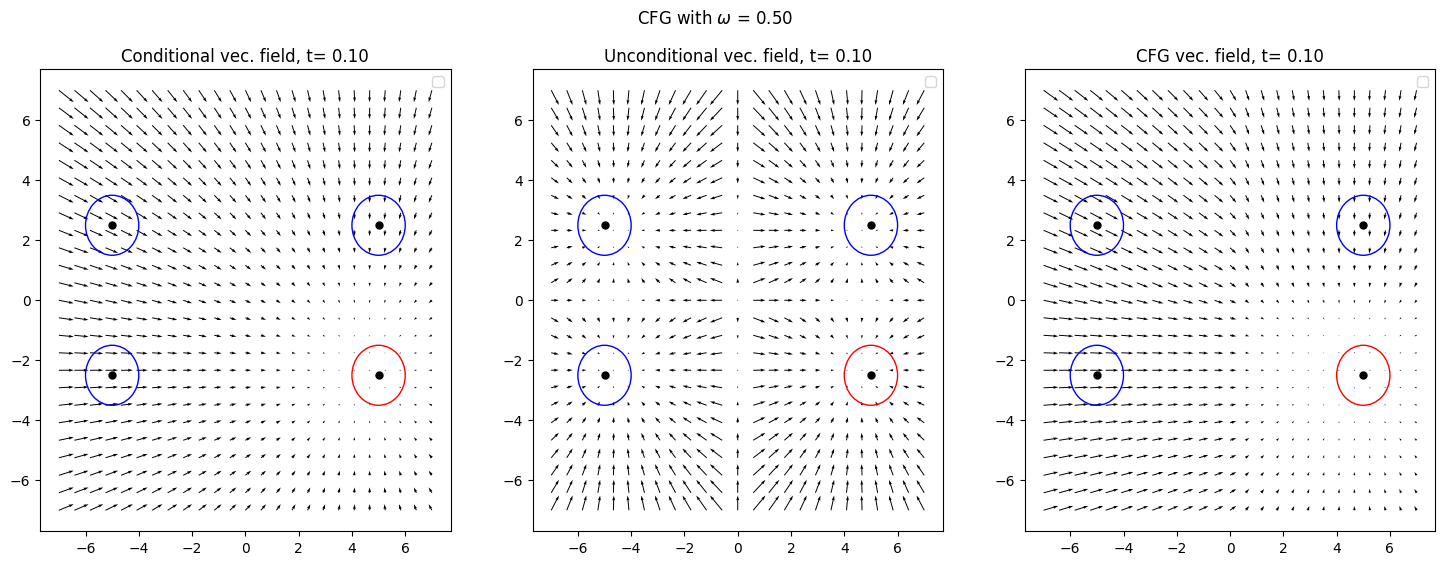

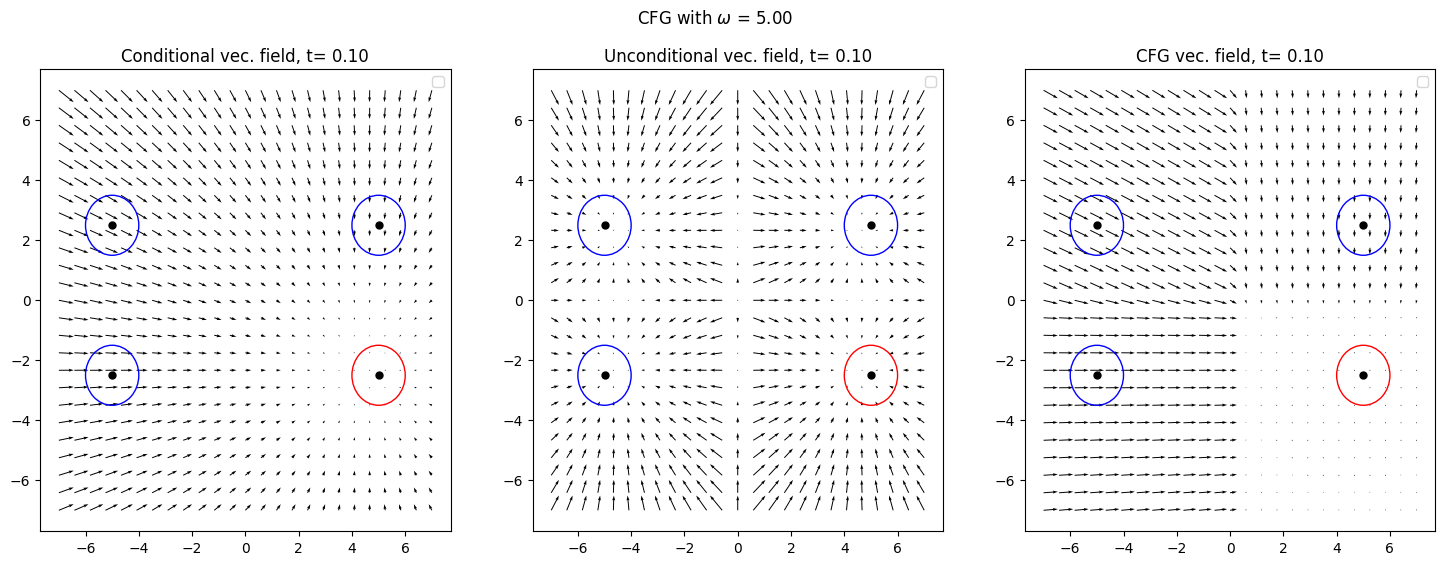

In [44]:
t = 0.1
sigma = 1.
_, _, _, _= plot_all_three(m1, m2, t, dt, sigma, omega=0.1, n=25, min=-7, max=7, plot=True)
_, _, _, _= plot_all_three(m1, m2, t, dt, sigma, omega=.5, n=25, min=-7, max=7, plot=True)
_, _, _, _= plot_all_three(m1, m2, t, dt, sigma, omega=5., n=25, min=-7, max=7, plot=True)

In [40]:
(m1+m2).numpy()

array([5. , 2.5], dtype=float32)

In [ ]:
omega = 1.
images = []

t_values = torch.flip(torch.linspace(0,2., steps=100),dims=[0])
for t_value in tqdm(t_values):
    t = torch.tensor([t_value])
    inp, conc1, conc2, conc = plot_all_three(m1, m2, t, dt, sigma, omega=omega, n=25, min=min_val, max=max_val)
    # Plot the function
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create 3 subplots side by side
    for ax, c in zip(axes, [conc1, conc2, conc]):
        ax.set_title(['Conditional vec. field, t= %.2f' % t, 'Unconditional vec. field, t= %.2f' % t, 'CFG vec. field, t= %.2f' % t][axes.tolist().index(ax)])
        ax.quiver(inp[:, :, 0], inp[:, :, 1], c[:, :, 0], c[:, :, 1])
        for plots in [m1+m2, m1-m2, -m1+m2, -m1-m2]:
            ax.scatter(plots[0], plots[1], color='black', s=25)
        # Add contours of 2D Gaussian
        for mean in [(m1+m2).numpy(), (-m1+m2).numpy(), -(m1+m2).numpy()]:
            circle1 = plt.Circle(mean, 1., color='b', fill=False)
            ax.add_patch(circle1)
        circle1 = plt.Circle((m1-m2).numpy(), 1., color='r', fill=False)
        ax.add_patch(circle1)
        ax.legend()
    # Save the plot to a temporary file
    plt_path = f'temp_plots/temp_{t_value:.2f}.png'
    fig.suptitle("CFG with $\omega$ = %.2f" % omega)
    plt.savefig(plt_path)
    plt.close()
    
    # Append the image to the list
    images.append(imageio.imread(plt_path))
# Create a GIF
imageio.mimsave('gifs/combined_2d_w'+str(omega)+'.gif', images, duration=0.05)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_263520/4000017707.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t, sigma = torch.tensor(t), torch.tensor(sigma)
/tmp/ipykernel_263520/1153726654.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


# Forward ODE

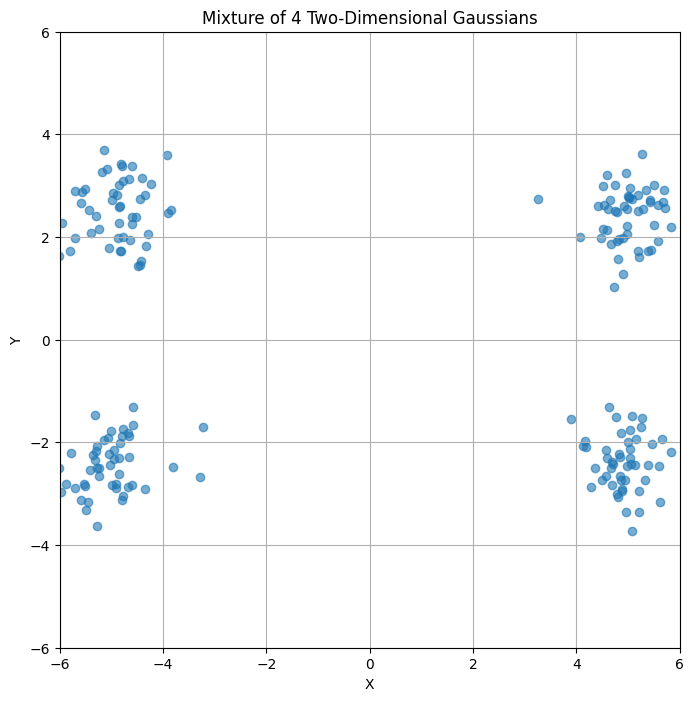

In [27]:
sigma = .3

means = torch.stack([m1+m2, m1-m2,-m1+m2,-m1-m2])
covariances = torch.tensor([[[1., 0.], [0., 1.]]] * 4) * sigma
weights = torch.tensor([0.25, 0.25, 0.25, 0.25]) 
num_samples = 200
samples = []
for mean, cov, weight in zip(means, covariances, weights):
    num_samples_gaussian = int(num_samples * weight)
    distribution = torch.distributions.MultivariateNormal(mean, cov)
    samples_gaussian = distribution.sample((num_samples_gaussian,))
    samples.append(samples_gaussian)

all_samples = torch.cat(samples)

plt.figure(figsize=(8, 8))
plt.scatter(all_samples[:, 0].numpy(), all_samples[:, 1].numpy(), alpha=0.6)
plt.title('Mixture of 4 Two-Dimensional Gaussians')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.grid(True)
plt.show()


In [ ]:
finish_time = 4.
num_iter = 200

s_cfg, images_new, x_prev = [], [], all_samples

for t_ in tqdm(torch.linspace(0., finish_time, steps=num_iter)):
    t_ = torch.tensor([t_])
    x_cur = []
    for x in x_prev:
        Gamma_t = sigma**2*torch.exp(-2*t_) + dt
        s_cfg = uncond_score(x, t_, m1, m2, Gamma_t)
        eta = torch.randn_like(x) * torch.sqrt(torch.tensor(2*dt))
        x_new = x + 2 * dt * s_cfg + eta
        x_cur.append(x_new)
    x_cur = torch.stack(x_cur)
    x_prev = x_cur
    
    plt.figure()
    plt.scatter(x_cur[:,0].detach().numpy(), x_cur[:,1].detach().numpy(), alpha=0.6)
    plt.suptitle("Time is t: "+str(round(t_.item(),2)))
    plt_path = f'temp_plots/temp_{t_.item():.2f}.png'
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.savefig(plt_path)
    plt.close()
    
    images_new.append(imageio.imread(plt_path))
    

imageio.mimsave('gifs/forward_2d.gif', images_new, fps=10)

100%|██████████| 200/200 [00:35<00:00,  5.62it/s]


# Reverse ODE

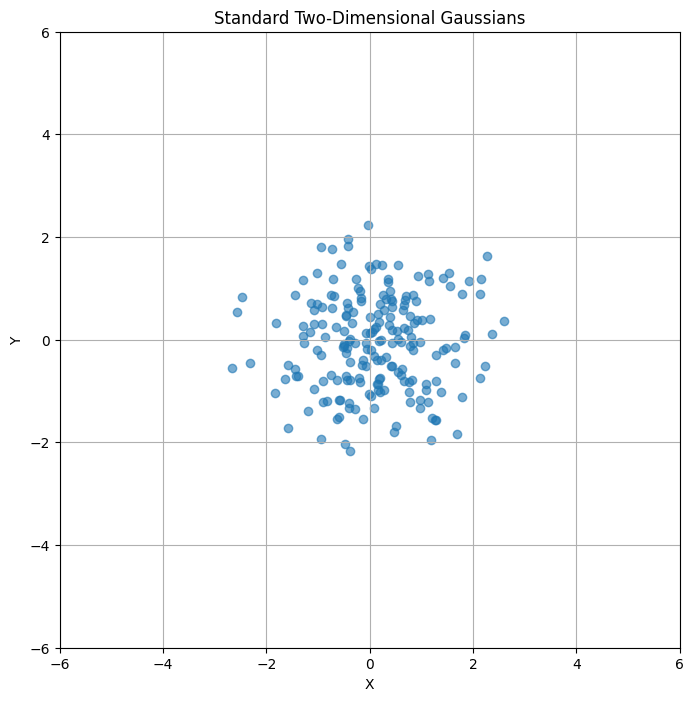

In [29]:
num_samples = 200
mean, cov = torch.tensor([0., 0.]), torch.tensor([[1., 0.], [0., 1.]])
distribution = torch.distributions.MultivariateNormal(mean, cov)
all_samples = distribution.sample((num_samples,))

plt.figure(figsize=(8, 8))
plt.scatter(all_samples[:, 0].numpy(), all_samples[:, 1].numpy(), alpha=0.6)
plt.title('Standard Two-Dimensional Gaussians')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.grid(True)
plt.show()


In [35]:
sigma = .5
dt = 0.01
finish_time = 4.

s_cfg, images_new, x_prev = [], [], all_samples


timesteps = torch.tensor(np.arange(0, finish_time+dt, dt))
for t in tqdm(timesteps):
    t_end = torch.tensor(finish_time)
    x_cur = []
    
    for x in x_prev:
        Gamma_t = sigma**2*torch.exp(-2*(t_end-t)) + dt
        # score = uncond_score(x, t_end-t, m1, m2, Gamma_t)
        # score = cond_score(x, t_end-t, m1, m2, Gamma_t, label=0)
        score = cfg(x, t_end-t, m1, m2, Gamma_t, omega=.5, label=0)
        eta = torch.randn_like(x) * torch.sqrt(torch.tensor(2*dt))
        x_new = x + 2 * dt * score + eta
        x_cur.append(x_new)
    x_cur = torch.stack(x_cur)
    
    
    plt.figure()
    plt.scatter(x_cur[:,0].detach().numpy(), x_cur[:,1].detach().numpy(), alpha=0.6)
    for plots in [m1+m2, m1-m2, -m1+m2, -m1-m2]:
        plt.scatter(plots[0], plots[1], color='r', s=20)
    
    plt.suptitle("Time is t: "+str(round((t_end-t).item(),2)))
    plt_path = f'temp_plots/temp_{t.item():.2f}.png'
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.savefig(plt_path)
    plt.close()
    images_new.append(imageio.imread(plt_path))
    
    x_prev = x_cur

imageio.mimsave('gifs/backward_2d.gif', images_new, fps=20)

100%|██████████| 401/401 [01:35<00:00,  4.21it/s]
